In [2]:
import random
import math
import os
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [3]:
def calculate_rotated_bbox_for_yolo_v8(data: dict, normalize: bool = False) -> list[tuple]:
    """
    Calculate the absolute coordinates of the corners of a rotated bounding box or 
    normalize them if required.
    
    This function takes the bounding box information and applies rotation to get the 
    coordinates of the four corners after rotation. If normalization is required, it 
    scales these coordinates to be between 0 and 1.

    Args:
    - data (dict): A dictionary containing the bounding box information.
    - normalize (bool): A flag to indicate if the coordinates should be normalized.

    Returns:
    - list of tuples: A list containing tuples, each with the (x, y) coordinates 
                        of a corner of the bounding box, either absolute or normalized.
    """
    # Convert percentages to absolute values if not normalizing
    if not normalize:
        width = data['width'] / 100 * data['original_width']
        height = data['height'] / 100 * data['original_height']
        top_left_x = data['x'] / 100 * data['original_width']
        top_left_y = data['y'] / 100 * data['original_height']
    else:
        # If normalizing, use percentages as they are
        width = data['width']
        height = data['height']
        top_left_x = data['x']
        top_left_y = data['y']
    
    # Convert rotation angle to radians and adjust for clockwise rotation
    angle_rad = math.radians(data['rotation'])

    # Coordinates of the bounding box corners prior to rotation
    corners = [(0, 0), (width, 0), (width, height), (0, height)]

    # Rotate each corner around the top-left corner
    rotated_corners = []
    for x, y in corners:
        # Apply the rotation matrix to each corner point
        rotated_x = x * math.cos(angle_rad) - y * math.sin(angle_rad)
        rotated_y = x * math.sin(angle_rad) + y * math.cos(angle_rad)
        
        # Translate the rotated points back by adding the coordinates of the top-left corner
        # If normalizing, convert the coordinates to a scale from 0 to 1
        if normalize:
            rotated_corners.append(((rotated_x + top_left_x) / data['original_width'], 
                                    (rotated_y + top_left_y) / data['original_height']))
        else:
            rotated_corners.append((rotated_x + top_left_x, rotated_y + top_left_y))

    return rotated_corners

def convert_annotations_to_yolo_obb(json_folder_path: str, output_folder_path: str, 
                                    class_list: list, normalize: bool = False):
    """
    Convert rotated bounding box annotations from JSON files to YOLO OBB format and save to TXT files.
    Optionally normalize the bounding box coordinates.

    Args:
    - json_folder_path (str): The path to the folder containing JSON annotation files.
    - output_folder_path (str): The path to the folder where TXT files will be saved.
    - class_list (list): A list of class names ordered according to their class index.
    - normalize (bool): A flag to indicate if the coordinates should be normalized.

    Outputs:
    - TXT files containing the annotations in YOLO OBB format, saved to the destination folder.
    """
    # Create the destination folder if it does not exist
    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)
    
    # Loop through all the files in the json directory
    for file_name in os.listdir(json_folder_path):
        if file_name.endswith('.json'):
            # Read the JSON file
            with open(os.path.join(json_folder_path, file_name), 'r') as json_file:
                data = json.load(json_file)
            
            # Prepare the content for the TXT file
            txt_content = []
            for annotation in data['label']:
                # Calculate the rotated bounding box coordinates
                corners = calculate_rotated_bbox_for_yolo_v8(annotation, normalize=normalize)
                # Get the class index
                class_index = class_list.index(annotation['rectanglelabels'][0])
                # Convert coordinates to the YOLO OBB format, absolute or normalized
                yolo_obb = [class_index] + [val for corner in corners for val in corner]
                txt_content.append(' '.join(map(str, yolo_obb)))
            
            # Write the content to the corresponding TXT file
            txt_file_name = os.path.splitext(data['image'].split('/')[-1])[0] + '.txt'
            with open(os.path.join(output_folder_path, txt_file_name), 'w') as txt_file:
                txt_file.write('\n'.join(txt_content))

In [8]:
source_path = "/Users/jocareher/Downloads/face_dataset/val/images"
output_path = "/Users/jocareher/Downloads/face_dataset/val/labels"
normalize = False
class_list = ["3/4_left_sideview", "3/4_rigth_sideview", "Frontal", "Left_sideview", "Right_sideview"]

convert_annotations_to_yolo_obb(json_folder_path=source_path,
                                output_folder_path=output_path,
                                class_list=class_list,
                                normalize=normalize)

In [10]:
import os
import random
from PIL import Image

def create_yolov8_pairs(root_directory: str) -> list[tuple]:
    """
    Traverse the 'images' and 'labels' subdirectories within the specified root directory.
    Pair each image with its corresponding annotation file, if available.

    Args:
    - root_directory (str): The path to the root directory containing 'images' and 'labels' folders.

    Returns:
    - List of tuples: Each tuple contains the path to an image file and a list of annotation strings.
    """
    # Path to the subdirectory containing image files
    images_dir = os.path.join(root_directory, 'images')
    # Path to the subdirectory containing annotation files
    labels_dir = os.path.join(root_directory, 'labels')

    pairs = []
    # Loop through all files in the images directory
    for image_name in os.listdir(images_dir):
        # Check if the file is a JPEG image
        if image_name.endswith('.jpg'):
            # Extract the base name without the file extension
            base_name = os.path.splitext(image_name)[0]
            # Construct the corresponding label file name
            label_name = base_name + '.txt'
            # Full paths to the image and label files
            image_path = os.path.join(images_dir, image_name)
            label_path = os.path.join(labels_dir, label_name)
            
            # Check if the annotation file exists
            if os.path.exists(label_path):
                # Read all lines from the annotation file
                with open(label_path, 'r') as file:
                    annotations = file.readlines()
                # Append the image path and its annotations as a tuple to the pairs list
                pairs.append((image_path, annotations))
    return pairs

def draw_yolov8_annotations_on_images(pairs: list[tuple],
                               class_list: list[str],
                               num_images_to_display: int,
                               show_labels: bool = True,
                               show_axis: str = "on") -> None:
    """
    Draw annotations on images as polygons and display them in a grid.
    Optionally include class labels aligned with the top edge of the bounding box.

    Args:
    - pairs (list of tuples): A list containing tuples of image paths and annotation data.
    - class_list (list of str): A list of class names ordered by their corresponding class index.
    - num_images_to_display (int): The number of images to display on the grid.
    - show_labels (bool, optional): If True, display class labels. Default is True.
    - show_axis (str, optional): Control the visibility of the axis. Default is "on".

    Outputs:
    - Displays a grid of images with the respective annotations.
    """
    # Select a random subset of image-annotation pairs
    selected_pairs = random.sample(pairs, min(num_images_to_display, len(pairs)))
    
    # Determine the number of rows and columns for the grid based on the number of images
    grid_cols = int(np.ceil(np.sqrt(num_images_to_display)))
    grid_rows = int(np.ceil(num_images_to_display / grid_cols))
    # Create a grid of subplots
    fig, axs = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(15, 15))
    axs = axs.flatten()  # Flatten to 1D array for easy indexing

    # Loop through the axes and hide any that won't be used
    for ax in axs[num_images_to_display:]:
        ax.axis('off')

    for idx, ax in enumerate(axs[:num_images_to_display]):
        # Extract the image path and annotations for the current index from the selected pairs
        image_path, annotation_data = selected_pairs[idx]
        # Open the image file and display it on the current axis
        img = Image.open(image_path)
        ax.imshow(img)
        
        # Iterate over each annotation for the current image
        for annotation in annotation_data:
            # Extract the class index and convert it to the class name
            class_index = int(annotation.split(' ')[0])
            class_name = class_list[class_index]
            # Parse the annotation coordinates and reshape them into a 2x4 matrix
            points = list(map(float, annotation.strip().split(' ')[1:]))
            points = np.array(points).reshape((4, 2))
            
            # Create a polygon patch from the annotation points and add it to the axis
            poly = patches.Polygon(points, closed=True, fill=False, edgecolor='blue')
            ax.add_patch(poly)
            
            # If labels should be shown, calculate the text properties and display it
            if show_labels:
                top_edge_vec = points[1] - points[0]  # Vector representing the top edge of the box
                angle = np.arctan2(top_edge_vec[1], top_edge_vec[0])
                
                # Set the position for the label text at the midpoint of the top edge
                label_pos = (points[0] + points[1]) / 2
                text_x, text_y = label_pos
                margin = 3  # Margin for the text position above the top edge
                
                # Adjust text position based on the orientation of the top edge
                if top_edge_vec[0] < 0:  # If the edge is oriented to the left
                    angle -= np.pi  # Adjust the angle to keep text orientation consistent

                # The text is placed above the top edge, considering the margin
                ax.text(text_x, text_y - margin, class_name, rotation=np.degrees(angle),
                        color='red', fontsize=9, ha='center', va='bottom', rotation_mode='anchor')
                
        # Display axis on the images
        ax.axis(show_axis)
    
    plt.tight_layout()
    plt.show()

In [11]:
pairs = create_yolov8_pairs("/Users/jocareher/Downloads/face_dataset/test")


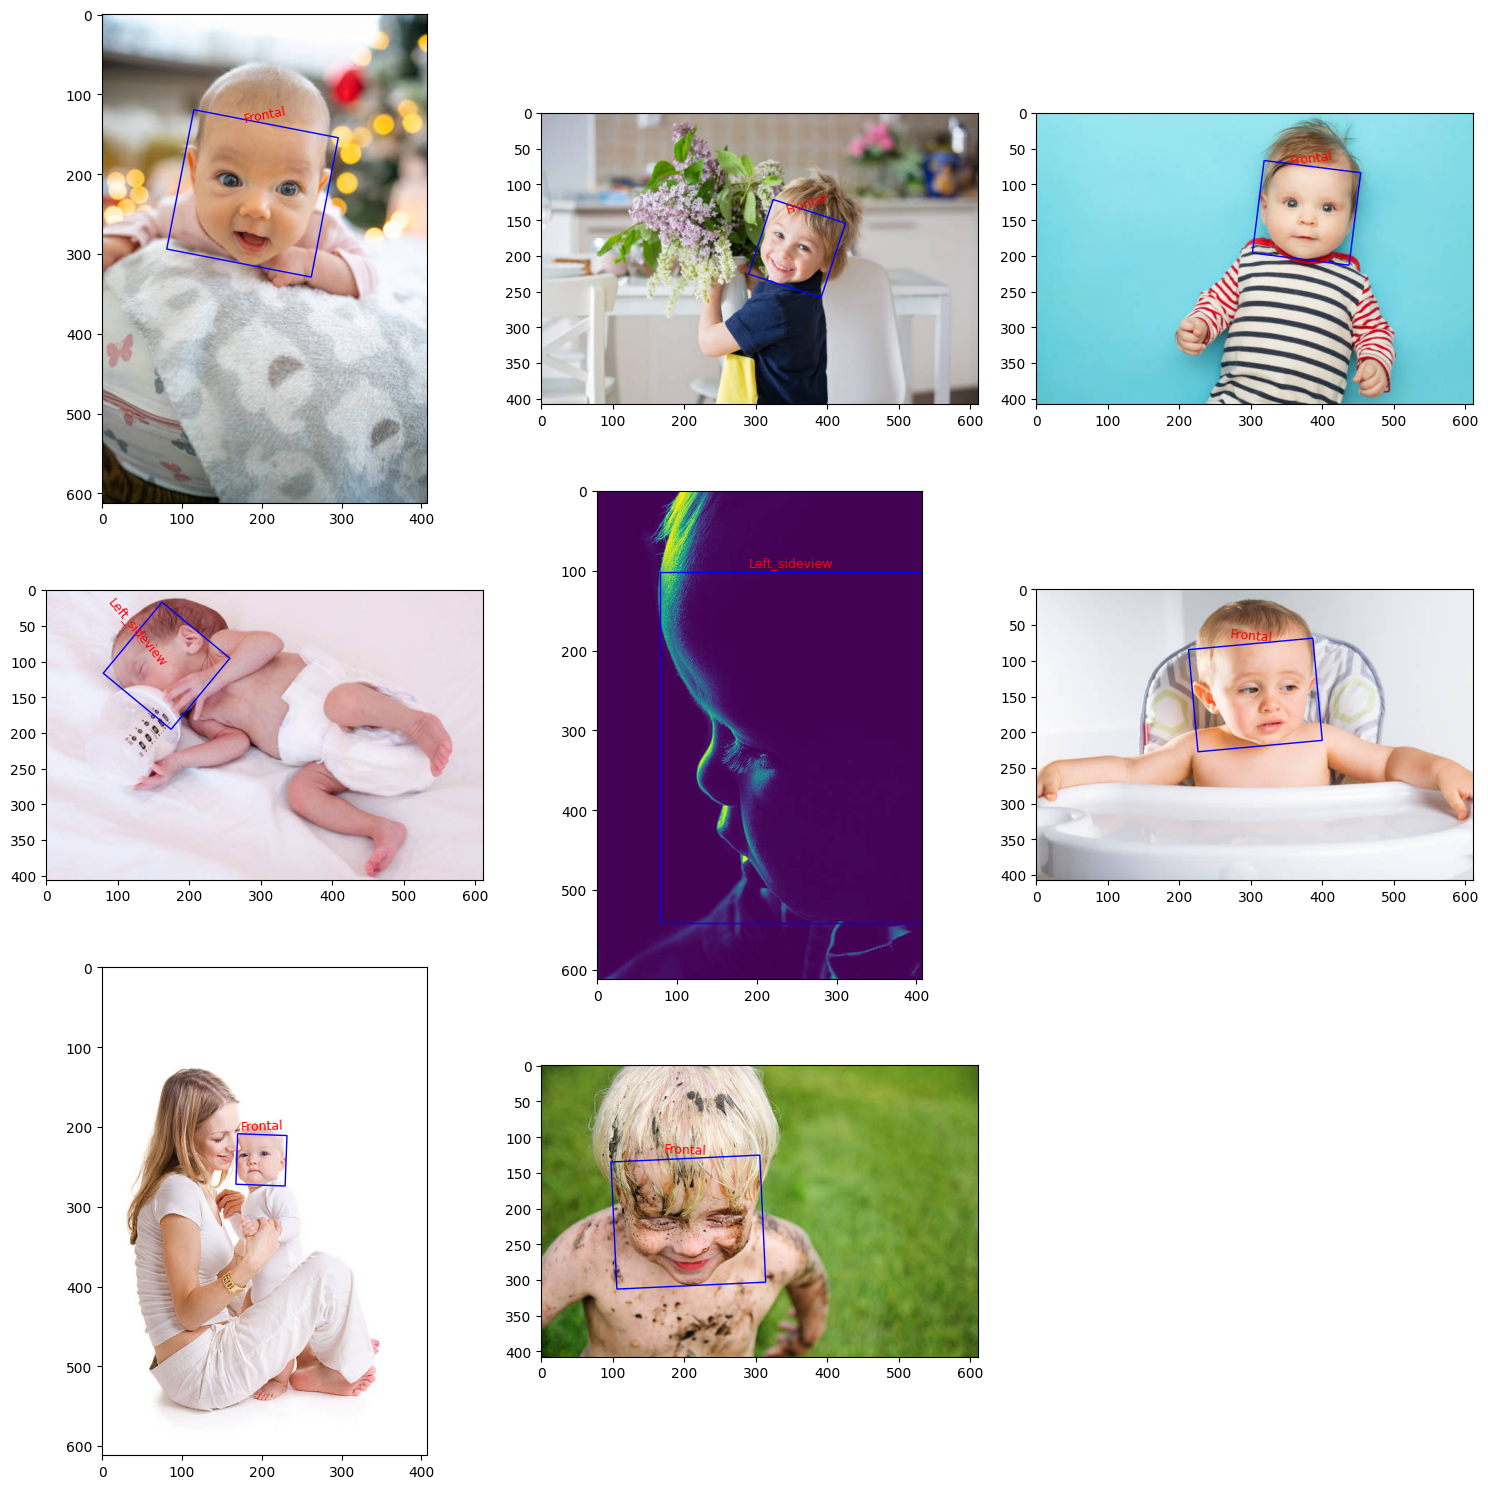

In [12]:
draw_yolov8_annotations_on_images(pairs=pairs,
                                  class_list=class_list,
                                  num_images_to_display=8,
                                  )

In [18]:
def normalize_annotations(labels_dir: str, target_size=(640, 640)):
    """
    Normalize annotations of oriented bounding boxes assuming images will be resized 
    to a target input size when input to the YOLOv8 model. This version only requires 
    the path to the labels directory.

    Args:
    - labels_dir (str): The path to the directory containing label files.
    - target_size (tuple): The target size (width, height) for normalization.
    """
    # Create a directory for normalized labels if it doesn't exist
    normalized_labels_dir = os.path.join(labels_dir, 'normalized_labels')
    if not os.path.exists(normalized_labels_dir):
        os.makedirs(normalized_labels_dir)

    # Loop through each label file in the directory
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            # Construct the path to the original and the new label file
            label_path = os.path.join(labels_dir, label_file)
            normalized_label_path = os.path.join(normalized_labels_dir, label_file)
            
            # Open and read the original label file
            with open(label_path, 'r') as file:
                annotations = file.readlines()

            # List to store normalized annotations
            normalized_annotations = []
            for annotation in annotations:
                parts = annotation.strip().split()
                class_index = int(parts[0])  # Extract the class index
                coords = list(map(float, parts[1:]))  # Extract and convert coordinates to float
                
                # Normalize each coordinate
                normalized_coords = [
                    coord / target_size[i % 2] for i, coord in enumerate(coords)
                ]
                
                # Construct the normalized annotation line
                normalized_line = f"{class_index} " + ' '.join(f"{coord}" for coord in normalized_coords)
                normalized_annotations.append(normalized_line)
            
            # Write the normalized annotations to a new file in the normalized_labels directory
            with open(normalized_label_path, 'w') as file:
                file.write('\n'.join(normalized_annotations))

In [21]:
source_path = "/Users/jocareher/Downloads/face_dataset/test"
normalize_annotations(root_directory=source_path)

In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s-obb.pt')  # load a pretrained model (recommended for training)

# Train the model with 2 GPUs
results = model.train(data="/Users/jocareher/Library/CloudStorage/OneDrive-Personal/Educación/PhD_UPF_2023/Face_Detection/configs/yolo.yaml", epochs=100, imgsz=640, device='mps')

100%|██████████| 22.2M/22.2M [00:00<00:00, 30.2MB/s]


Ultralytics YOLOv8.1.9 🚀 Python-3.9.18 torch-2.2.0 MPS (Apple M2 Max)
engine/trainer: task=obb, mode=train, model=yolov8s-obb.pt, data=/Users/jocareher/Library/CloudStorage/OneDrive-Personal/Educación/PhD_UPF_2023/Face_Detection/configs/yolo.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

train: Scanning /Users/jocareher/Downloads/face_dataset/train/labels.cache... 5342 images, 0 backgrounds, 19 corrupt: 100%|██████████| 5342/5342 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/train/images/face_img_3134.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0053]
train: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/train/images/face_img_3144.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0022]
train: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/train/images/face_img_3281.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.055]
train: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/train/images/face_img_3346.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0361]
train: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/train/images/face_img_3366.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0255]
train: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/train/images/face_img_6001.jpg: ignoring corrupt ima


val: Scanning /Users/jocareher/Downloads/face_dataset/val/labels.cache... 798 images, 0 backgrounds, 6 corrupt: 100%|██████████| 798/798 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/val/images/face_img_4715.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0937]
val: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/val/images/face_img_4803.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1111]
val: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/val/images/face_img_4885.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0879]
val: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/val/images/face_img_5034.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0231]
val: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/val/images/face_img_5373.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.103]
val: WARNING ⚠️ /Users/jocareher/Downloads/face_dataset/val/images/face_img_5446.jpg: ignoring corrupt image/label: non-normalized

Plotting labels to runs/obb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/obb/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G       2.55      4.492      2.193         14        640: 100%|██████████| 333/333 [13:04<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/50 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/50 [00:36<29:51, 36.56s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/50 [01:08<26:50, 33.56s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 3/50 [01:19<18:15, 23.31s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 4/50 [01:34<15:27, 20.16s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 5/50 [01:44<12:30, 16.67s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 6/50 [01:53<10:08, 13.82s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 7/50 [02:04<09:16, 12.95s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 8/50 [02:18<09:16, 13.24s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 9/50 [02:28<08:27, 12.37s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 10/50 [02:42<08:31, 12.79s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 11/50 [02:53<08:03, 12.41s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  24%|██▍       | 12/50 [03:03<07:15, 11.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▌       | 13/50 [03:15<07:08, 11.58s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 14/50 [03:26<06:57, 11.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 15/50 [03:39<07:01, 12.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 16/50 [03:54<07:16, 12.84s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  34%|███▍      | 17/50 [04:09<07:22, 13.41s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▌      | 18/50 [04:22<07:05, 13.30s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 19/50 [04:39<07:25, 14.37s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 20/50 [04:59<08:02, 16.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 21/50 [05:13<07:29, 15.49s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 22/50 [05:21<06:14, 13.39s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 23/50 [05:35<06:01, 13.38s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 24/50 [05:48<05:43, 13.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 25/50 [06:05<06:00, 14.42s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 26/50 [06:22<06:07, 15.33s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 27/50 [06:38<05:55, 15.48s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 28/50 [06:56<05:59, 16.35s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 29/50 [07:15<05:54, 16.86s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 30/50 [07:25<05:01, 15.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 31/50 [07:42<04:55, 15.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 32/50 [07:59<04:45, 15.85s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  66%|██████▌   | 33/50 [08:14<04:27, 15.76s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 34/50 [08:31<04:16, 16.04s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 35/50 [08:45<03:51, 15.40s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  72%|███████▏  | 36/50 [09:02<03:43, 15.99s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 37/50 [09:53<05:45, 26.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 38/50 [10:06<04:28, 22.37s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 39/50 [10:55<05:35, 30.52s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 40/50 [11:12<04:23, 26.32s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 41/50 [12:02<05:00, 33.41s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 42/50 [12:46<04:52, 36.53s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 43/50 [13:01<03:31, 30.28s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  88%|████████▊ | 44/50 [14:01<03:54, 39.14s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 45/50 [14:37<03:10, 38.17s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 46/50 [15:09<02:24, 36.21s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 47/50 [15:39<01:43, 34.53s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  96%|█████████▌| 48/50 [16:00<01:00, 30.31s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  98%|█████████▊| 49/50 [16:17<00:26, 26.43s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [17:16<00:00, 20.73s/it]


                   all        792        827     0.0043     0.0168    0.00278   0.000503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      2.275      3.147      1.991         22        640: 100%|██████████| 333/333 [25:31<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/50 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/50 [00:11<09:38, 11.81s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/50 [00:28<11:47, 14.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 3/50 [00:41<10:45, 13.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 4/50 [00:51<09:21, 12.21s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 5/50 [01:15<12:29, 16.66s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 6/50 [01:33<12:27, 16.99s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 7/50 [01:48<11:42, 16.34s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 8/50 [02:05<11:33, 16.51s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 9/50 [02:27<12:37, 18.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 10/50 [02:50<13:13, 19.84s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 11/50 [03:01<11:00, 16.93s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  24%|██▍       | 12/50 [03:16<10:27, 16.50s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▌       | 13/50 [03:33<10:18, 16.72s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 14/50 [03:48<09:40, 16.13s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 15/50 [04:05<09:37, 16.51s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 16/50 [04:13<07:50, 13.83s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  34%|███▍      | 17/50 [04:27<07:39, 13.91s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▌      | 18/50 [04:40<07:19, 13.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 19/50 [04:53<06:49, 13.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 20/50 [05:03<06:09, 12.31s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 21/50 [05:17<06:13, 12.87s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 22/50 [05:27<05:37, 12.06s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 23/50 [05:38<05:14, 11.65s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 24/50 [05:46<04:34, 10.56s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 25/50 [06:05<05:28, 13.13s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 26/50 [06:20<05:29, 13.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 27/50 [06:33<05:09, 13.44s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 28/50 [06:41<04:20, 11.85s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 29/50 [06:58<04:43, 13.51s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 30/50 [07:11<04:22, 13.14s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 31/50 [07:34<05:07, 16.17s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 32/50 [07:48<04:39, 15.52s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  66%|██████▌   | 33/50 [08:14<05:17, 18.68s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 34/50 [08:44<05:55, 22.19s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 35/50 [09:06<05:29, 21.96s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  72%|███████▏  | 36/50 [09:19<04:30, 19.32s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 37/50 [09:42<04:24, 20.36s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 38/50 [10:08<04:25, 22.10s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 39/50 [10:32<04:08, 22.63s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 40/50 [10:48<03:27, 20.76s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 41/50 [11:02<02:49, 18.79s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 42/50 [11:19<02:25, 18.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 43/50 [11:35<02:01, 17.43s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  88%|████████▊ | 44/50 [12:01<02:00, 20.02s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 45/50 [12:18<01:36, 19.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 46/50 [12:34<01:13, 18.29s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 47/50 [12:45<00:48, 16.10s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  96%|█████████▌| 48/50 [13:10<00:37, 18.75s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  98%|█████████▊| 49/50 [13:33<00:19, 19.88s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [13:55<00:00, 16.72s/it]


                   all        792        827      0.812    0.00339     0.0018   0.000456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.249       3.04      1.975         22        640: 100%|██████████| 333/333 [36:40<00:00,  6.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/50 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/50 [00:13<11:08, 13.65s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/50 [00:38<16:14, 20.29s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 3/50 [01:03<17:42, 22.60s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 4/50 [01:29<18:06, 23.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 5/50 [01:53<18:03, 24.07s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 6/50 [02:06<14:52, 20.28s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 7/50 [02:29<14:58, 20.90s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 8/50 [02:58<16:29, 23.55s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 9/50 [03:18<15:23, 22.53s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 10/50 [03:48<16:29, 24.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 11/50 [04:03<14:12, 21.86s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  24%|██▍       | 12/50 [04:25<13:51, 21.88s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▌       | 13/50 [04:42<12:39, 20.53s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 14/50 [04:58<11:28, 19.14s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 15/50 [05:24<12:15, 21.02s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 16/50 [05:40<11:04, 19.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  34%|███▍      | 17/50 [06:04<11:28, 20.86s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▌      | 18/50 [06:29<11:51, 22.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 19/50 [07:06<13:43, 26.55s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 20/50 [07:20<11:22, 22.75s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 21/50 [07:32<09:32, 19.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 22/50 [07:51<08:59, 19.27s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 23/50 [08:17<09:34, 21.28s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 24/50 [08:33<08:33, 19.74s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 25/50 [08:46<07:22, 17.69s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 26/50 [09:04<07:08, 17.87s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 27/50 [09:28<07:36, 19.84s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 28/50 [09:51<07:34, 20.67s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 29/50 [09:59<05:56, 16.97s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 30/50 [10:14<05:25, 16.28s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 31/50 [10:28<04:57, 15.66s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 32/50 [11:08<06:52, 22.90s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  66%|██████▌   | 33/50 [11:27<06:09, 21.73s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 34/50 [11:55<06:15, 23.49s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 35/50 [12:26<06:29, 25.95s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  72%|███████▏  | 36/50 [12:41<05:17, 22.70s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 37/50 [12:54<04:14, 19.56s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 38/50 [13:21<04:24, 22.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 39/50 [13:48<04:18, 23.52s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 40/50 [14:09<03:45, 22.58s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 41/50 [14:23<03:00, 20.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 42/50 [14:29<02:07, 15.98s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 43/50 [14:45<01:50, 15.72s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  88%|████████▊ | 44/50 [15:12<01:54, 19.16s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 45/50 [15:28<01:31, 18.34s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 46/50 [15:50<01:17, 19.30s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 47/50 [16:07<00:56, 18.72s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  96%|█████████▌| 48/50 [16:29<00:39, 19.57s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  98%|█████████▊| 49/50 [16:45<00:18, 18.69s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [16:52<00:00, 20.25s/it]


                   all        792        827      0.843    0.00814    0.00481    0.00141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.182      2.916      1.953         18        640: 100%|██████████| 333/333 [41:21<00:00,  7.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/50 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/50 [00:23<18:57, 23.21s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/50 [00:46<18:35, 23.24s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 3/50 [01:12<19:15, 24.59s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   8%|▊         | 4/50 [01:34<18:02, 23.53s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 5/50 [01:57<17:22, 23.16s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  12%|█▏        | 6/50 [02:12<15:07, 20.63s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▍        | 7/50 [02:37<15:44, 21.97s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 8/50 [03:09<17:33, 25.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 9/50 [03:34<17:15, 25.25s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 10/50 [03:51<14:58, 22.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 11/50 [04:17<15:24, 23.72s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  24%|██▍       | 12/50 [04:59<18:27, 29.13s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▌       | 13/50 [05:27<17:53, 29.03s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 14/50 [05:47<15:42, 26.17s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 15/50 [06:13<15:17, 26.21s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  32%|███▏      | 16/50 [06:46<15:54, 28.07s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  34%|███▍      | 17/50 [07:10<14:45, 26.83s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▌      | 18/50 [07:39<14:46, 27.71s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 19/50 [08:05<13:57, 27.03s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 20/50 [08:29<13:03, 26.10s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  42%|████▏     | 21/50 [08:45<11:09, 23.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 22/50 [09:03<10:01, 21.47s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 23/50 [09:09<07:38, 16.99s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 24/50 [09:35<08:34, 19.78s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 25/50 [09:42<06:38, 15.95s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 26/50 [10:01<06:43, 16.81s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 27/50 [10:19<06:35, 17.19s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 28/50 [10:38<06:25, 17.52s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  58%|█████▊    | 29/50 [10:59<06:30, 18.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 30/50 [11:15<05:56, 17.81s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 31/50 [11:35<05:53, 18.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▍   | 32/50 [12:03<06:22, 21.27s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  66%|██████▌   | 33/50 [12:22<05:50, 20.61s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  68%|██████▊   | 34/50 [12:40<05:20, 20.02s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 35/50 [13:14<06:01, 24.09s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  72%|███████▏  | 36/50 [13:30<05:03, 21.66s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 37/50 [13:46<04:21, 20.08s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 38/50 [14:02<03:45, 18.80s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 39/50 [14:09<02:48, 15.34s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 40/50 [14:27<02:40, 16.04s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 41/50 [14:47<02:35, 17.28s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 42/50 [15:03<02:14, 16.83s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▌ | 43/50 [15:19<01:56, 16.58s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  88%|████████▊ | 44/50 [15:35<01:39, 16.53s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 45/50 [15:54<01:25, 17.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  92%|█████████▏| 46/50 [16:28<01:28, 22.22s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 47/50 [16:35<00:53, 17.68s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  96%|█████████▌| 48/50 [16:49<00:33, 16.54s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  98%|█████████▊| 49/50 [17:06<00:16, 16.83s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [17:26<00:00, 20.93s/it]


                   all        792        827      0.205     0.0254    0.00394    0.00108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.178      2.837      1.953         26        640:  49%|████▊     | 162/333 [21:27<22:38,  7.95s/it] 


KeyboardInterrupt: 

In [7]:
from ultralytics import YOLO

# Load a model
model = YOLO('/Users/jocareher/Library/CloudStorage/GoogleDrive-jocareher95@gmail.com/My Drive/runs_yolo/obb/train/weights/best.pt')  # load a pretrained model (recommended for training)

# Define path to the image file
source = '/Users/jocareher/Downloads/face_dataset/test/images/face_img_4396.jpg'

# Run inference on 'bus.jpg' with arguments
model.predict(task= "obb", 'source', save=False, conf=0.5)


FileNotFoundError: source does not exist